In [12]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

from utils import correct_prediction, levenshtein_distance

In [2]:
val_dir = 'Data/attacks-val'
test_dir = 'Data/attacks-test'

language_dir = 'Tamil-V2'

val_path = os.path.join(val_dir, language_dir)
test_path = os.path.join(test_dir, language_dir)

In [8]:
data_path = test_path

In [9]:
result_df = pd.DataFrame()
for model in tqdm(os.listdir(data_path), desc='Models'):
    data_path_model = os.path.join(data_path, model)
    for mode in tqdm(os.listdir(data_path_model), desc='Modes'):
        data_path_model_mode = os.path.join(data_path_model, mode)
        for attack in tqdm(os.listdir(data_path_model_mode), desc='Attacks'):
            data_path_model_mode_attack = os.path.join(data_path_model_mode, attack)
            image_fns = [fn for fn in os.listdir(data_path_model_mode_attack) if fn.endswith('.png')]
            text_list = [fn.split('_')[0] for fn in image_fns]
            text_prediction_list = [fn.split('_')[-1][:-4] for fn in image_fns]
            attack_list = [attack] * len(text_list)
            mode_list = [mode] * len(text_list)
            model_list = [model] * len(text_list)
            df = pd.DataFrame({
                'model': model_list,
                'mode': mode_list,
                'attack': attack_list,
                'image_fn': image_fns,
                'actual': text_list,
                'prediction': text_prediction_list,
            })
            result_df = result_df.append(df, ignore_index=True)

result_df = result_df.sort_values(by=['model', 'mode', 'attack', 'image_fn']).reset_index(drop=True)
result_df['prediction_corrected'] = result_df['prediction'].apply(correct_prediction)
result_df['edit_distance'] = result_df.apply(levenshtein_distance, axis=1)
print(result_df.shape)
result_df.head()

Models:   0%|          | 0/1 [00:00<?, ?it/s]

Modes:   0%|          | 0/3 [00:00<?, ?it/s]

Attacks:   0%|          | 0/6 [00:00<?, ?it/s]

Attacks:   0%|          | 0/6 [00:00<?, ?it/s]

Attacks:   0%|          | 0/6 [00:00<?, ?it/s]

(39312, 8)


,model,mode,attack,image_fn,actual,prediction,prediction_corrected,edit_distance
0,crnn-1,multi-label,Attack-0,ஃபயர்பக்_30_2705_0_க-------ர்-ள-ள்.png,ஃபயர்பக்,க-------ர்-ள-ள்,கர்ளள்,5
1,crnn-1,multi-label,Attack-0,ஃபயர்வால்_30_532_2_ஃ---பயயர்-வா--ல்.png,ஃபயர்வால்,ஃ---பயயர்-வா--ல்,ஃபயர்வால்,0
2,crnn-1,multi-label,Attack-0,ஃபிலிமனசு_30_3888_2_ஐ-----லி-ம-ன-ச்.png,ஃபிலிமனசு,ஐ-----லி-ம-ன-ச்,ஐலிமனச்,4
3,crnn-1,multi-label,Attack-0,அகச்_30_4528_0_அ------க----ச்.png,அகச்,அ------க----ச்,அகச்,0
4,crnn-1,multi-label,Attack-0,அகனள்_30_498_3_அ-----க--ன--ள்.png,அகனள்,அ-----க--ன--ள்,அகனள்,0


In [18]:
def compute_accuracy(df, max_edit_distance=0):
    accuracy =  (df['edit_distance'] <= max_edit_distance).sum() / len(df)
    return accuracy

accuracy_df = pd.DataFrame(result_df.groupby(['mode', 'attack']).apply(compute_accuracy, max_edit_distance=0), columns=['accuracy-e0'])
accuracy_df['accuracy-e1'] = pd.DataFrame(result_df.groupby(['mode', 'attack']).apply(compute_accuracy, max_edit_distance=1))
accuracy_df['accuracy-e2'] = pd.DataFrame(result_df.groupby(['mode', 'attack']).apply(compute_accuracy, max_edit_distance=2))
accuracy_df['accuracy-e3'] = pd.DataFrame(result_df.groupby(['mode', 'attack']).apply(compute_accuracy, max_edit_distance=3))
accuracy_df['accuracy-e4'] = pd.DataFrame(result_df.groupby(['mode', 'attack']).apply(compute_accuracy, max_edit_distance=4))
accuracy_df = accuracy_df.T
accuracy_df

mode        multi-label                                                    \
attack         Attack-0  Attack-1  Attack-2  Attack-3  Attack-4  Attack-5   
accuracy-e0    0.858059  0.742674  0.655678  0.399725  0.311355  0.043498   
accuracy-e1    0.913004  0.865385  0.836081  0.667582  0.577381  0.127289   
accuracy-e2    0.970238  0.950092  0.935440  0.845238  0.780220  0.248168   
accuracy-e3    0.988553  0.974359  0.965659  0.928114  0.891484  0.426740   
accuracy-e4    0.995421  0.990842  0.984890  0.962454  0.949634  0.607601   

mode         original                                                    \
attack       Attack-0  Attack-1  Attack-2  Attack-3  Attack-4  Attack-5   
accuracy-e0  0.841575  0.723443  0.631868  0.325092  0.213828  0.032967   
accuracy-e1  0.906136  0.847070  0.808608  0.618132  0.509615  0.105769   
accuracy-e2  0.967033  0.943681  0.929029  0.818681  0.737179  0.230769   
accuracy-e3  0.984890  0.973443  0.969322  0.916209  0.878205  0.458791   
accuracy-e4  0.991758  0.986264  0.980769  0.958791  0.939560  0.658883   

mode          unicode                                                    
attack       Attack-0  Attack-1  Attack-2  Attack-3  Attack-4  Attack-5  
accuracy-e0  0.874084  0.757784  0.662546  0.372711  0.244963  0.021978  
accuracy-e1  0.951465  0.907967  0.866300  0.684066  0.547619  0.071886  
accuracy-e2  0.972985  0.948260  0.935897  0.844780  0.764652  0.182692  
accuracy-e3  0.986264  0.977106  0.972070  0.925366  0.883242  0.373168  
accuracy-e4  0.992674  0.987637  0.983059  0.961081  0.941392  0.573718

<AxesSubplot:>

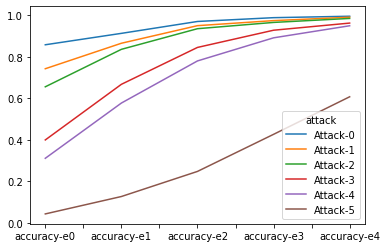

In [21]:
accuracy_df['multi-label'].plot()

<AxesSubplot:>

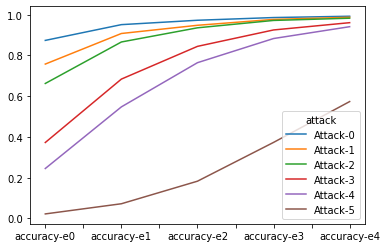

In [22]:
accuracy_df['unicode'].plot()

In [26]:
accuracy_df_2 = accuracy_df.T.reorder_levels(['attack', 'mode']).sort_index()
accuracy_df_2

accuracy-e0  accuracy-e1  accuracy-e2  accuracy-e3  \
attack   mode                                                              
Attack-0 multi-label     0.858059     0.913004     0.970238     0.988553   
         original        0.841575     0.906136     0.967033     0.984890   
         unicode         0.874084     0.951465     0.972985     0.986264   
Attack-1 multi-label     0.742674     0.865385     0.950092     0.974359   
         original        0.723443     0.847070     0.943681     0.973443   
         unicode         0.757784     0.907967     0.948260     0.977106   
Attack-2 multi-label     0.655678     0.836081     0.935440     0.965659   
         original        0.631868     0.808608     0.929029     0.969322   
         unicode         0.662546     0.866300     0.935897     0.972070   
Attack-3 multi-label     0.399725     0.667582     0.845238     0.928114   
         original        0.325092     0.618132     0.818681     0.916209   
         unicode         0.372711     0.684066     0.844780     0.925366   
Attack-4 multi-label     0.311355     0.577381     0.780220     0.891484   
         original        0.213828     0.509615     0.737179     0.878205   
         unicode         0.244963     0.547619     0.764652     0.883242   
Attack-5 multi-label     0.043498     0.127289     0.248168     0.426740   
         original        0.032967     0.105769     0.230769     0.458791   
         unicode         0.021978     0.071886     0.182692     0.373168   

                      accuracy-e4  
attack   mode                      
Attack-0 multi-label     0.995421  
         original        0.991758  
         unicode         0.992674  
Attack-1 multi-label     0.990842  
         original        0.986264  
         unicode         0.987637  
Attack-2 multi-label     0.984890  
         original        0.980769  
         unicode         0.983059  
Attack-3 multi-label     0.962454  
         original        0.958791  
         unicode         0.961081  
Attack-4 multi-label     0.949634  
         original        0.939560  
         unicode         0.941392  
Attack-5 multi-label     0.607601  
         original        0.658883  
         unicode         0.573718

<AxesSubplot:>

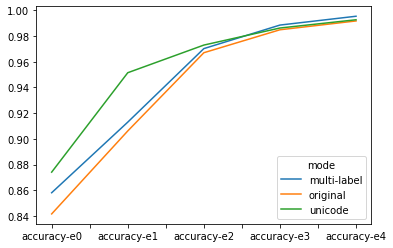

In [28]:
accuracy_df_2.T['Attack-0'].plot()

<AxesSubplot:>

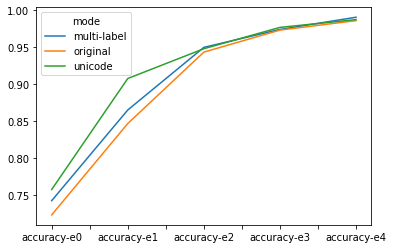

In [29]:
accuracy_df_2.T['Attack-1'].plot()

<AxesSubplot:>

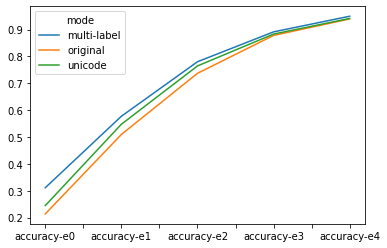

In [32]:
accuracy_df_2.T['Attack-4'].plot()